In [1]:
import numpy as np
import pyspiel 
import tensorflow.compat.v1 as tf
import torch 
import torch.nn as nn

import algorithms.rcfr as rcfr_tf
import pytorch.rcfr as rcfr_pt
tf.disable_v2_behavior()

tf.enable_eager_execution()

_GAME = pyspiel.load_game('kuhn_poker')
_BATCH_SIZE = 12

Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
def tnsorflow_example(game_name, num_epochs, iterations):
  game = pyspiel.load_game(game_name)

  models = []
  for _ in range(game.num_players()):
    models.append(
        rcfr_tf.DeepRcfrModel(
            game,
            num_hidden_layers=1,
            num_hidden_units=13,
            num_hidden_factors=8,
            use_skip_connections=True))

  buffer_size = -1
  truncate_negative = False
  bootstrap = False
  if buffer_size > 0:
    solver = rcfr_tf.ReservoirRcfrSolver(
        game,
        models,
        buffer_size,
        truncate_negative=truncate_negative)
  else:
    solver = rcfr_tf.RcfrSolver(
        game,
        models,
        truncate_negative=truncate_negative,
        bootstrap=bootstrap)

  def _train_fn(model, data):
    """Train `model` on `data`."""
    batch_size = 100
    step_size = 0.01
    data = data.shuffle(batch_size * 10)
    data = data.batch(batch_size)
    data = data.repeat(num_epochs)

    optimizer = tf.keras.optimizers.Adam(lr=step_size, amsgrad=True)

    @tf.function
    def _train():
      for x, y in data:
        optimizer.minimize(
            lambda: tf.losses.huber_loss(y, model(x), delta=0.01),  # pylint: disable=cell-var-from-loop
            model.trainable_variables)

    _train()

  # End of _train_fn
  result = []
  for i in range(iterations):
    solver.evaluate_and_update_policy(_train_fn)
    if i % 10 == 0:
      conv = pyspiel.exploitability(game, solver.average_policy())
      result.append(conv)
      # print("Iteration {} exploitability {}".format(i, conv))
  return result

In [3]:
def pytorch_example(game_name, num_epochs, iterations):
  game = pyspiel.load_game(game_name)

  models = []
  for _ in range(game.num_players()):
    models.append(
        rcfr_pt.DeepRcfrModel(
            game,
            num_hidden_layers=1,
            num_hidden_units=13,
            num_hidden_factors=8,
            use_skip_connections=True))

  buffer_size = -1
  truncate_negative = False
  bootstrap = False
  if buffer_size > 0:
    solver = rcfr_pt.ReservoirRcfrSolver(
        game,
        models,
        buffer_size,
        truncate_negative=truncate_negative)
  else:
    solver = rcfr_pt.RcfrSolver(
        game,
        models,
        truncate_negative=truncate_negative,
        bootstrap=bootstrap)

  def _train_fn(model, data):
    """Train `model` on `data`."""
    batch_size = 100
    num_epochs = 20
    step_size = 0.01
    
    data = torch.utils.data.DataLoader(data, batch_size=batch_size, shuffle=True)
    loss_fn = nn.SmoothL1Loss()
    optimizer = torch.optim.Adam(model.parameters(), lr=step_size, amsgrad=True)

    def _train(model, data):
      for epoch in range(num_epochs):
        for x, y in data:
          optimizer.zero_grad()
          output = model(x)
          loss = loss_fn(output, y)
          loss.backward()
          optimizer.step()

    _train(model, data)

  # End of _train_fn
  result = []
  for i in range(iterations):
    solver.evaluate_and_update_policy(_train_fn)
    if i % 10 == 0:
      conv = pyspiel.exploitability(game, solver.average_policy())
      result.append(conv)
      # print("Iteration {} exploitability {}".format(i, conv))
  return result

In [4]:
tensorflow_rcfr = []
pytorch_rcfr = []
num_epochs, iterations = 20, 100
for _ in range(10):
  tensorflow_rcfr.append(tnsorflow_example('kuhn_poker', num_epochs, iterations))
  pytorch_rcfr.append(pytorch_example('kuhn_poker', num_epochs, iterations))

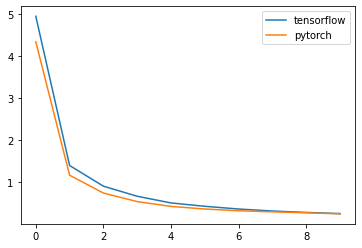

In [5]:
import matplotlib.pyplot as plt

x = [i for i in range(10)]
tf_exploitability = [sum(tfe) for tfe in zip(*tensorflow_rcfr)]
pt_exploitability = [sum(pte) for pte in zip(*pytorch_rcfr)]

plt.plot(x, tf_exploitability, label="tensorflow")
plt.plot(x, pt_exploitability, label="pytorch")

plt.legend()

plt.show()

In [6]:
tensorflow_rcfr = []
pytorch_rcfr = []
num_epochs, iterations = 200, 100
for _ in range(10):
  tensorflow_rcfr.append(tnsorflow_example('kuhn_poker', num_epochs, iterations))
  pytorch_rcfr.append(pytorch_example('kuhn_poker', num_epochs, iterations))

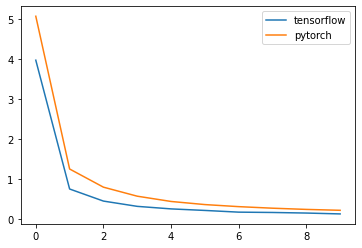

In [7]:
import matplotlib.pyplot as plt

x = [i for i in range(10)]
tf_exploitability = [sum(tfe) for tfe in zip(*tensorflow_rcfr)]
pt_exploitability = [sum(pte) for pte in zip(*pytorch_rcfr)]

plt.plot(x, tf_exploitability, label="tensorflow")
plt.plot(x, pt_exploitability, label="pytorch")

plt.legend()

plt.show()

In [ ]:
tensorflow_rcfr = []
pytorch_rcfr = []
num_epochs, iterations = 20, 100
for _ in range(10):
  tensorflow_rcfr.append(tnsorflow_example('leduc_poker', num_epochs, iterations))
  pytorch_rcfr.append(pytorch_example('leduc_poker', num_epochs, iterations))

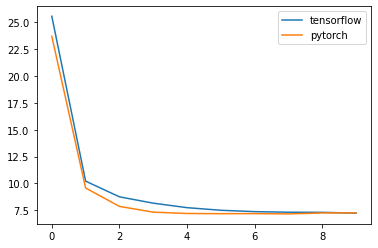

In [14]:
import matplotlib.pyplot as plt

x = [i for i in range(10)]
tf_exploitability = [sum(tfe) for tfe in zip(*tensorflow_rcfr)]
pt_exploitability = [sum(pte) for pte in zip(*pytorch_rcfr)]

plt.plot(x, tf_exploitability, label="tensorflow")
plt.plot(x, pt_exploitability, label="pytorch")

plt.legend()

plt.show()